In [161]:
import datasets
import roc_auc
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator

In [180]:
class EstimatorKNN(BaseEstimator):
    def __init__(self, n_neighbors=3, algorithm='ball_tree', metric='minkowski'):
        self.param = {}
        self.param['n_neighbors'] = n_neighbors
        self.param['algorithm'] = algorithm
        self.estimator = NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm, metric=metric)

    def fit(self, x):
        self.estimator.fit(x)
        return self 

    def predict(self, x):
        return [1.0]*len(x) 
    
    def decision_function(self, x, y=None):
        distances, indices = self.estimator.kneighbors(x)
        outlier_level = distances[:,-1]
        return outlier_level

    def score(self, x, y=None):
        scores = self.decision_function(x)
        return sum(scores)/len(scores)

    def get_params(self, deep=True):
        #return self.estimator.get_params(deep)
        return self.param

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter, value)
        return self
    
    def get_type(self):
        return 'kNN'

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors">scikit knn</a>

In [174]:
#ds = datasets.load('data/raw/02_1[12]_0[12]*')

path = data/raw/02_1[12]_0[12]*
data/raw/02_11_01_エネマネハウス_iphone_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/02_11_02_エネマネハウス_iphone_カバン_裏上_正常_まっすぐ帰宅
..............................
data/raw/02_12_01_エネマネハウス_iphone_胸ポケット_裏上_異常_まっすぐ外出
..............................
data/raw/02_12_02_エネマネハウス_iphone_ズボン_裏上_異常_まっすぐ外出
..............................


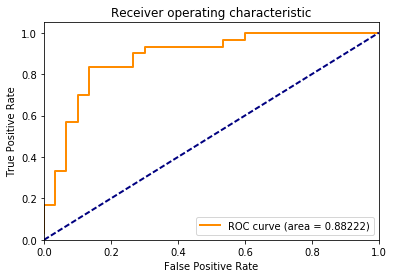

auc 0.88222


In [210]:
import importlib
#importlib.reload(roc_auc)
import roc_auc
import datasets

def eval01():
    base = '02_11_01'
    normal = '02_11_02'
    anomaly = '02_12_02'

    sensor_type = ['rssi.a','rssi.b', ['gyro.rotationRate.x','gyro.rotationRate.y', 'gyro.rotationRate.z']]
    n_record = 10
    drop_interval = 2
    ma_window = 2
    normalize = True
    
    # get data
    dfl_b = datasets.get_data(ds, title=base, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)[:3]
    dfl_n = datasets.get_data(ds, title=normal, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title=anomaly, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = EstimatorKNN()
    model.fit(data_b)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)
#    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=False)

    print('auc %.05f' % (auc))
    
eval01()